In [2]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [222]:
manaus_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)
geom = manaus.geometry()
manaus = ee.Geometry(geom)

In [2]:
atto_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_atto_footprint/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)
geom = atto.geometry()
atto = ee.Geomtetry(geom)

In [168]:
corumba_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_corumba_footprint/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)
geom = corumba.geometry()
corumba = ee.Geometry(geom)

In [3]:
mato_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_mato_footprint/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)
geom = mato.geometry()
mato = ee.Geometry(geom)

In [15]:
saop_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_saop_footprint/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)
geom = saop.geometry()
saop = ee.Geometry(geom)

In [16]:
#Select geom of interest
fc = saop

In [17]:
Map = geemap.Map()
Map.centerObject(fc, 10)
Map

Map(center=[-23.030299493730364, -48.74149613982401], controls=(WidgetControl(options=['position'], widget=HBo…

In [18]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)
ndre_params = ({'min': 0.0,'max': 1.0, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int()
cirrusBitMask = ee.Number(2).pow(11).int()
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [19]:
#Load sentinel-2 data
s2 = (ee.ImageCollection('COPERNICUS/S2')#Select S2 1-C level data
      .select(['B5','B8', 'QA60']) #Select necessary bands to reduce memory usage
      .filterBounds(fc) #Narrow data spatially
      .filterDate(ee.Date('2016-01-01'), ee.Date('2019-12-31')) #Select years of interest
      .sort('CLOUDY_PIXEL_PERCENTAGE', False) #Put smallest %cloud image on top of stack
      .map(addNDRE)) #calculate NDRE and add as band

#Load copernicus land cover data
lc = (ee.Image("COPERNICUS/Landcover/100m/Proba-V/Global/2015") #select 2015
      .select('discrete_classification') #choose classification band
      .clip(fc)) #clip to geom

In [20]:
#Create a masked s2 collection
masked = s2.map(maskS2clouds)

In [21]:
#15-day step
years = ee.List.sequence(2016, 2019)
period = ee.List.sequence(1, 365, 15)
col = masked.select('NDRE')

def byYear(y):
    y = ee.Number(y)
    def ndreStepList(startDoy):
        startDoy = ee.Number(startDoy)
        return (col
                .filter(ee.Filter.calendarRange(y, y.add(1), 'year'))
                .filter(ee.Filter.calendarRange(startDoy, startDoy.add(15), 'day_of_year'))
                .qualityMosaic('NDRE')
               .set('day_of_year', [startDoy, y]))
    return period.map(ndreStepList)

mapped_doy = years.map(byYear).flatten()
col = ee.ImageCollection.fromImages(mapped_doy)

In [22]:
col = col.map(lambda image: image.clip(fc))

In [23]:
info = col.size().getInfo()
print(info)

100


In [91]:
#Remove images with no data
col = col.filterMetadata('system:band_names', 'not_equals', [])

In [24]:
#Make sure there are no empty lists []
names = col.aggregate_array('system:band_names').getInfo()
print(names)
print(len(names))

[['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], [], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], [], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], ['NDRE'], []]
100


In [25]:
classed_imgs = col.map(lambda image: image.addBands(lc))

In [78]:
#Map.addLayer(classed_imgs, {}, 'test imgs')

In [26]:
def replaceNull(img):
    null_ndre = ee.List([img.get('NDRE'), -9999]).reduce(ee.Reducer.firstNonNull())
    return img.set({'NDRE': null_ndre})

classed_imgs.map(replaceNull)

In [27]:
names = classed_imgs.aggregate_array('system:band_names').getInfo()
print(names)
print(len(names))

[['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discrete_classification'], ['NDRE', 'discre

In [94]:
#Calculate mean per class
def classMean(img):
    reducer = (ee.Reducer
               .mean()
               .unweighted() #Allow values equal to 0
               .group(groupField= 1, groupName= 'class'))
    return img.set('mean', img.reduceRegion(reducer=reducer, geometry=fc, scale=20))
    
def classMeans(ic):
    stats = ic.map(classMean)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

In [95]:
#Create dictionary as 'group': [{'class': #, 'mean': #}, {etc}, {etc}]
d = classMeans(classed_imgs)

In [96]:
#Make a 2D array from dictionary
def newList(alist):
    list_name = []
    for value in alist:
        list_name.append(value['groups'])
    return list_name

l = newList(d)
l = np.array(l)
print(l)

[[{'class': 20, 'mean': 0.2751812611739202}
  {'class': 30, 'mean': 0.332016808803198}
  {'class': 40, 'mean': 0.3761712251153458} ...
  {'class': 122, 'mean': 0.40849465105113253}
  {'class': 124, 'mean': 0.3076001415746986}
  {'class': 126, 'mean': 0.37002530602557715}]
 [{'class': 20, 'mean': 0.3186098016864437}
  {'class': 30, 'mean': 0.3906371647655318}
  {'class': 40, 'mean': 0.4345554815089135} ...
  {'class': 122, 'mean': 0.5142338453058295}
  {'class': 124, 'mean': 0.42608817674736016}
  {'class': 126, 'mean': 0.45117208273733667}]
 [{'class': 20, 'mean': 0.31994205502209627}
  {'class': 30, 'mean': 0.39758927847313236}
  {'class': 40, 'mean': 0.4406602395715225} ...
  {'class': 122, 'mean': 0.5224635697538711}
  {'class': 124, 'mean': 0.44121906996238186}
  {'class': 126, 'mean': 0.461881801121182}]
 ...
 [{'class': 20, 'mean': 0.301139393041969}
  {'class': 30, 'mean': 0.36552338511107924}
  {'class': 40, 'mean': 0.32879257249046323} ...
  {'class': 122, 'mean': 0.4930713947

In [101]:
#Add missing lists
#Saop: [20, 30, 40, 50, 60, 80, 90, 112, 114, 116, 122, 124, 126]
#Atto: [20, 30, 80, 90, 112, 116, 122, 126]
replacement = [{'class': 20, 'mean': np.nan}, {'class': 30, 'mean': np.nan}, #Atto additions
               {'class': 80, 'mean': np.nan}, {'class': 90, 'mean': np.nan},
               {'class': 112, 'mean': np.nan}, {'class': 116, 'mean': np.nan},
               {'class': 122, 'mean': np.nan}, {'class': 126, 'mean': np.nan},
               {'class': 40, 'mean': np.nan}, {'class': 50, 'mean': np.nan}, #Saop additions
               {'class': 60, 'mean': np.nan}, {'class': 114, 'mean': np.nan},
               {'class': 124, 'mean': np.nan}]

In [59]:
#Atto: 5, 24
l = np.insert(l, 5, replacement, axis=0)
l = np.insert(l, 24, replacement, axis=0)
print(l)

[[{'class': 20, 'mean': 0.17064492079519455}
  {'class': 30, 'mean': 0.06731982395823162}
  {'class': 80, 'mean': 0.0029160533177517377}
  {'class': 90, 'mean': 0.1202304088845543}
  {'class': 112, 'mean': 0.35776110804802946}
  {'class': 116, 'mean': 0.1362279474737827} {'class': 122, 'mean': 0}
  {'class': 126, 'mean': 0.0728353387653158}]
 [{'class': 20, 'mean': 0.3749049296878999}
  {'class': 30, 'mean': 0.20927787165602163}
  {'class': 80, 'mean': -0.029001523988183685}
  {'class': 90, 'mean': 0.2621181905592232}
  {'class': 112, 'mean': 0.5188017720899321}
  {'class': 116, 'mean': 0.38633950449997}
  {'class': 122, 'mean': 0.44622339367866515}
  {'class': 126, 'mean': 0.3861292260190409}]
 [{'class': 20, 'mean': 0.21360926556971765}
  {'class': 30, 'mean': 0.17183804143257633}
  {'class': 80, 'mean': 0.0710920837753587}
  {'class': 90, 'mean': 0.2017197285978888}
  {'class': 112, 'mean': 0.38559304343475076}
  {'class': 116, 'mean': 0.24289603722331693}
  {'class': 122, 'mean': 0

In [60]:
print(len(l))

100


In [102]:
#Add missing lists for Saop
#position 9, 24, 99
l = np.insert(l, 9, replacement, axis=0)
l = np.insert(l, 24, replacement, axis=0)
l = np.insert(l, 99, replacement, axis=0)

In [103]:
print(len(l))

100


In [104]:
#Look for empty dicitonaries
def findBad(alist):
    for obj in alist:
        for blist in alist:
            for dictionary in blist:
                if len(dictionary) == 0:
                    return('BAD BOY DETECTED')
                else:
                    return('YOU GOOD')
findBad(l)

'YOU GOOD'

In [105]:
test_list = []
for element in l:
    for value in element:
        test_list.append(value['class'])

labels_list = list(set(test_list))
labels_list.sort()
print(labels_list)

[20, 30, 40, 50, 60, 80, 90, 112, 114, 116, 122, 124, 126]


In [106]:
#create separate lists for each class
def makeList(alist, num):
    test_list = []
    for element in alist:
        for value in element:
            if value['class'] == int(num):
                test_list.append(value['mean'])
    return test_list

list_20 = makeList(alist=l, num=20)
list_30 = makeList(alist=l, num=30)
list_40 = makeList(alist=l, num=40)
list_50 = makeList(alist=l, num=50)
list_60 = makeList(alist=l, num=60)
list_80 = makeList(alist=l, num=80)
list_90 = makeList(alist=l, num=90)
list_112 = makeList(alist=l, num=112)
list_114 = makeList(alist=l, num=114)
list_116 = makeList(alist=l, num=116)
list_122 = makeList(alist=l, num=122)
list_124 = makeList(alist=l, num=124)
list_126 = makeList(alist=l, num=126)

In [107]:
list20 = [np.nan if v == 0 else v for v in list_20]
list30 = [np.nan if v == 0 else v for v in list_30]
list40 = [np.nan if v == 0 else v for v in list_40]
list50 = [np.nan if v == 0 else v for v in list_50]
list60 = [np.nan if v == 0 else v for v in list_60]
list80 = [np.nan if v == 0 else v for v in list_80]
list90 = [np.nan if v == 0 else v for v in list_90]
list112 = [np.nan if v == 0 else v for v in list_112]
list114 = [np.nan if v == 0 else v for v in list_114]
list116 = [np.nan if v == 0 else v for v in list_116]
list122 = [np.nan if v == 0 else v for v in list_122]
list124 = [np.nan if v == 0 else v for v in list_124]
list126 = [np.nan if v == 0 else v for v in list_126]

In [108]:
#Make sure above lists are same length
print(len(list20))
print(len(list112))

100
100


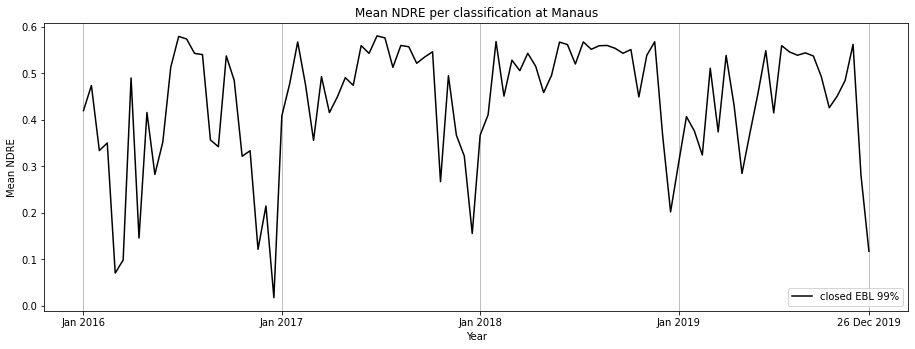

In [252]:
#Manaus
plt.axes([2, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')

#plt.plot(list20, label='shrubs <1%')
#plt.plot(list30, label='herbaceous <1%')
#plt.plot(list40, label='agriculture <1%')
plt.plot(list112, color='black', label='closed EBL 99%')
#plt.plot(list116, label='closed forest <1%')
#plt.plot(list122, label='open ebl <1%')
#plt.plot(list126, label='open forest <1%')
plt.legend(loc = "lower right")

plt.title("Mean NDRE per classification at Manaus")
plt.ylabel("Mean NDRE")
plt.xlabel("Year")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

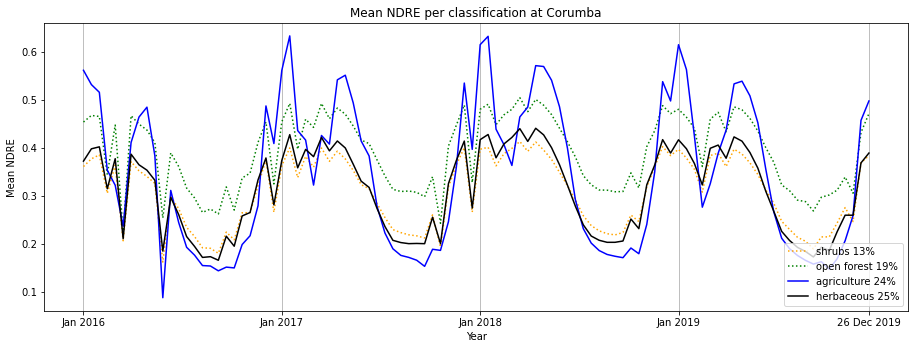

In [220]:
#Corumba
plt.axes([2, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')

plt.plot(list20, color='orange', linestyle=':', label='shrubs 13%')
plt.plot(list126, color='green', linestyle=':', label='open forest 19%')
plt.plot(list40, color='blue', label='agriculture 24%')
plt.plot(list30, color='black', label='herbaceous 25%')
#plt.plot(list50, label='urban <1%')
#plt.plot(list60, label='bare <1%')
#plt.plot(list80, label='water 6%')
#plt.plot(list90, label='wetland 1%')
#plt.plot(list112, label='closed EBL 3%')
#plt.plot(list114, label='closed DBL <1%')
#plt.plot(list116, label='closed forest 8%')
#plt.plot(list122, label='open EBL <1%')
#plt.plot(list124, label='open DBL <1%')
plt.legend(loc = "lower right")

plt.title("Mean NDRE per classification at Corumba")
plt.ylabel("Mean NDRE")
plt.xlabel("Year")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

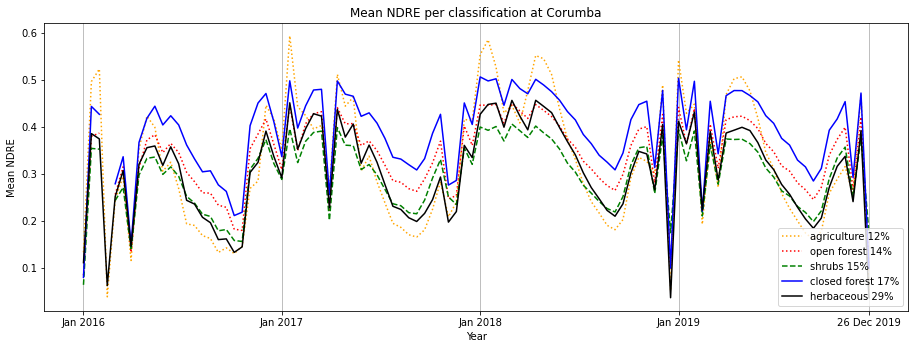

In [317]:
#Mato
#[(20, 15.5), (30, 28.7), (40, 11.6), (50, 0.2), 
# (60, 0.1), (80, 1.7), (90, 0.4), (112, 5.9), 
# (114, 4.5), (116, 17.5), (122, <.1), (124, <.1), 
# (126, 13.8)]
plt.axes([2, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')

plt.plot(list40, color = 'orange', linestyle=':', label='agriculture 12%')
plt.plot(list126, color = 'red', linestyle=':', label='open forest 14%')
plt.plot(list20, color = 'green', linestyle='--', label='shrubs 15%')
plt.plot(list116, color = 'blue', label='closed forest 17%')
plt.plot(list30, color = 'black', label='herbaceous 29%')
#plt.plot(list50, label='urban <1%')
#plt.plot(list60, label='bare <1%')
#plt.plot(list80, label='water 2%')
#plt.plot(list90, label='wetland <1%')
#plt.plot(list112, label='closed EBL 6%')
#plt.plot(list114, label='closed DBL 5%')
#plt.plot(list122, label='open EBL <1%')
#plt.plot(list124, label='open DBL <1%')

plt.legend(loc = "lower right")
plt.title("Mean NDRE per classification at Corumba")
plt.ylabel("Mean NDRE")
plt.xlabel("Year")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.show()

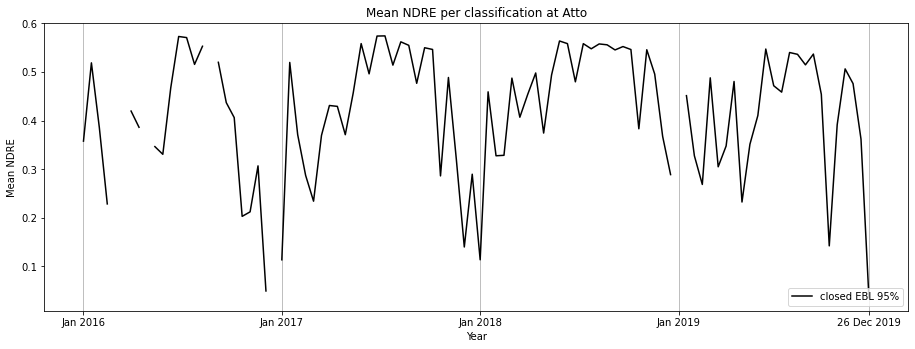

In [66]:
#Atto [20, 30, 80, 90, 112, 116, 122, 126]
#[(20, <1), (30, <1),(80, 1.8), (90, 2), 
#(112, 94.5), (116, 1), (122, <1), (126, <1)]

plt.axes([2, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')

#plt.plot(list20, label='shrubs <1%')
#plt.plot(list30, label='herbaceous <1%')
#plt.plot(list80, label='water 2%')
#plt.plot(list90, label='wetland 2%')
plt.plot(list112, color='black', label='closed EBL 95%')
#plt.plot(list116, label='closed forest 1%')
#plt.plot(list122, label='open ebl <1%')
#plt.plot(list126, label='open forest <1%')

plt.legend(loc = "lower right")
plt.title("Mean NDRE per classification at Atto")
plt.ylabel("Mean NDRE")
plt.xlabel("Year")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

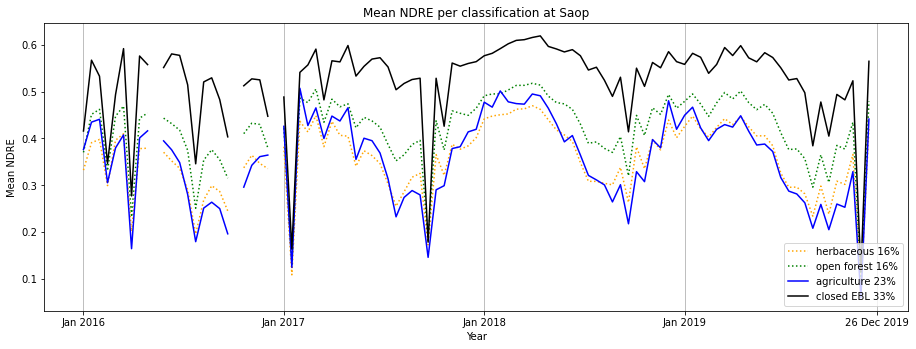

In [112]:
#Saop 
#[20, 30, 40, 50, 60, 80, 90, 112, 114, 116, 122, 124, 126]
#[(20, <1), (30, 16), (40, 23), (50, <1), 
#(60, <1), (80, <1), (90, <1), (112, 33), 
#(114, <1), (116, 7), (122, 1), (124, <1), (126, 16)]

plt.axes([2, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')

#plt.plot(list20, label='shrubs <1')
#plt.plot(list50, label='urban <1')
#plt.plot(list60, label='bare <1')
#plt.plot(list80, label='water <1')
#plt.plot(list90, label='wetland <1')
#plt.plot(list114, label='closed DBL <1')
#plt.plot(list116, label='closed forest 7%')
#plt.plot(list122, label='open ebl 1')
#plt.plot(list124, label='open DBL <1')

plt.plot(list30, color='orange', linestyle=':', label='herbaceous 16%')
plt.plot(list126, color='green', linestyle=':', label='open forest 16%')
plt.plot(list40, color='blue', label='agriculture 23%')
plt.plot(list112, color='black', label='closed EBL 33%')

plt.legend(loc = "lower right")
plt.title("Mean NDRE per classification at Saop")
plt.ylabel("Mean NDRE")
plt.xlabel("Year")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()